# How to Use Reservoir Computing Modules
The overall process is:
1. Generate 2 datasets: `training_data` and `reservoir_transient_data`. 
2. The reservoir is trained using `training_data`. 
3. Using `W_out` from step 2, run a `transient_forecast_res` on 
`reservoir_transient_data`.
4. Use `transient_forecast_res` to predict the dynamical system over the 
reservoir transient period, call it `transient_preds`. 
5. Generate `test_data` whose initial condition is the last data point in `reservoir_transient_data`.
6. Generate `forecast_res` initialised using the last reservoir state of `transient_forecast_res`.
5. Use `forecast_res` to predict the system, and evaluate these predictions against 
the `test_data`. 

In [101]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.facecolor"] = "white"

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from data import data
from reservoir import reservoir as res
from error import error

In [80]:
LAMBDA = 0.9056
SEED = 42
STATE = np.random.RandomState(SEED)

NUM_TRIALS = 100

# reservoir dimension
N = 100

In [81]:
hyperparams = {
    'GAMMA': 7.7,
    'SIGMA': 0.81,
    'RHO_IN': 0.37,
    'K': 3,
    'RHO_R': 0.41
}

simulation_parameters = {
    "DEL_T": 0.02,          # time step size
    "STEPS": 30000,         # total steps
    "TRANSIENT": 10000,       # TRANSIENT 
    # n = STEPS - TRANSIENT
    "ALPHA": 0.001,         # Tikhonov regularisation constant
    "d": 3,
    "INITIAL_STATE_RANGE": 5
}

## Datasets

In [82]:
training_ic = STATE.choice(np.linspace(-5, 5), 3)
reservoir_transient_ic = STATE.choice(np.linspace(-5, 5), 3)

training_data = data.generate_lorenz_63(
    initial_state=training_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=simulation_parameters["TRANSIENT"]
)

reservoir_transient_data = data.generate_lorenz_63(
    initial_state=reservoir_transient_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=simulation_parameters["TRANSIENT"]
)

## Train Reservoir

In [83]:
W_in = res.generate_W_in(hyperparams=hyperparams, shape=(N, simulation_parameters["d"]), state=STATE)
W_r = res.generate_W_r(hyperparams=hyperparams, shape=(N, N), state=STATE)

In [84]:
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [85]:
W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=simulation_parameters["ALPHA"]
)

## Generate Transient Reservoir Preds

In [86]:
unmodified_transient_forecast_res, transient_forecast_res = res.generate_forecast_reservoir(
    r_0=np.dot(W_in, reservoir_transient_data[0]),
    data=reservoir_transient_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [87]:
transient_preds = res.readout_network(res=transient_forecast_res, W_out=W_out)

In [88]:
transient_preds

array([[  6.46053786, -21.68900468,  17.61523967],
       [  4.24440328, -18.12307078,  12.96374857],
       [  2.67798571, -17.88754604,  10.67305853],
       ...,
       [-14.68705026, -21.45551633,  27.25711101],
       [-15.83181455, -20.55460229,  32.13614733],
       [-16.47229694, -18.05024227,  36.53533883]])

## Evaluate Actual Prediction

In [89]:
test_ic = transient_preds[-1]
test_data = data.generate_lorenz_63(
    initial_state=test_ic,
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"],
    transient=0
)

In [90]:
unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
    r_0=unmodified_transient_forecast_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=W_r,
    W_in=W_in,
    W_out=W_out,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)

In [91]:
preds = res.readout_network(res=forecast_res, W_out=W_out)
preds

array([[-16.47229694, -18.05024227,  36.53533883],
       [-16.44067514, -14.28605163,  39.9056703 ],
       [-15.60761041,  -9.8416954 ,  41.58060044],
       ...,
       [ -5.11227885,  -8.656629  ,  13.95625718],
       [ -5.87688003,  -9.99489893,  14.22932001],
       [ -6.75667407, -11.48192758,  14.81135711]])

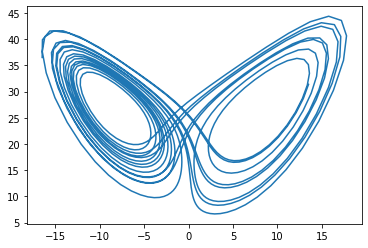

In [92]:
start = data.lyapunov_to_steps(0, LAMBDA, simulation_parameters["DEL_T"])
end = data.lyapunov_to_steps(15, LAMBDA, simulation_parameters["DEL_T"])
x_range = LAMBDA * simulation_parameters["DEL_T"] * np.array(range(start, end))
plt.plot(preds[start:end, 0], preds[start:end, 2])

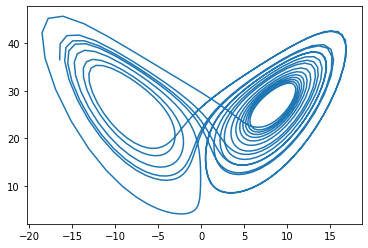

In [93]:
plt.plot(test_data[start:end, 0], test_data[start:end, 2])

Text(0, 0.5, 'x')

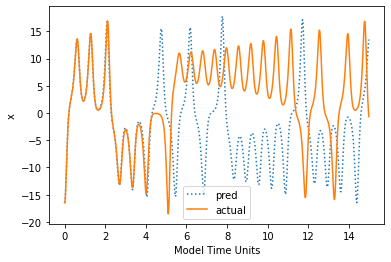

In [94]:
plt.plot(x_range, preds[start:end, 0], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 0], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("x")

Text(0, 0.5, 'y')

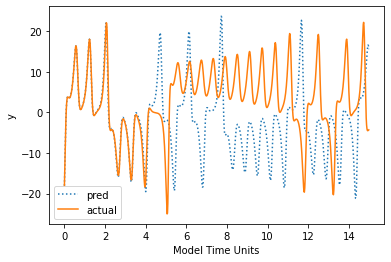

In [95]:
plt.plot(x_range, preds[start:end, 1], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 1], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("y")

Text(0, 0.5, 'z')

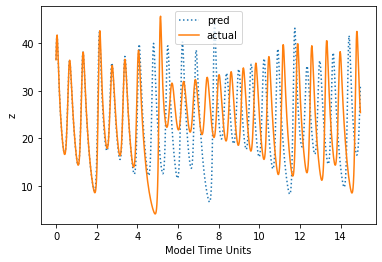

In [96]:
plt.plot(x_range, preds[start:end, 2], label="pred", linestyle="dotted")
plt.plot(x_range, test_data[start:end, 2], label="actual")
plt.legend()
plt.xlabel("Model Time Units")
plt.ylabel("z")

In [97]:
print(error.RMSE(test_data, preds))
print(error.griffith_epsilon_1(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA))
print(error.griffith_epsilon(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA))

[0.81129813 0.92127189 0.86317022]
3.9876215097757615
0.9873185122878755


## With Hyperparameter Optimisation

In [98]:
def objective(hyperparams: list) -> float:
    hyperparams = {
        'GAMMA': hyperparams[0],
        'SIGMA': hyperparams[1],
        'RHO_IN': hyperparams[2],
        'K': hyperparams[3],
        'RHO_R': hyperparams[4]
    }
    
    # generate internals
    W_in = res.generate_W_in(
        hyperparams=hyperparams,
        shape=(N, simulation_parameters["d"]),
        state=STATE
    )
    W_r = res.generate_W_r(
        hyperparams=hyperparams,
        shape=(N, N),
        state=STATE
    )

    # train reservoir
    training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )
    W_out = res.generate_W_out(
        data=training_data,
        res=training_res,
        alpha=simulation_parameters["ALPHA"]
    )

    # let reservoir run for transient period
    unmodified_transient_forecast_res, transient_forecast_res = res.generate_forecast_reservoir(
        r_0=np.dot(W_in, reservoir_transient_data[0]),
        data=reservoir_transient_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )
    transient_preds = res.readout_network(res=transient_forecast_res, W_out=W_out)

    # actual test period
    test_ic = transient_preds[-1]
    test_data = data.generate_lorenz_63(
        initial_state=test_ic,
        del_t=simulation_parameters["DEL_T"],
        steps=simulation_parameters["STEPS"],
        transient=0
    )
    unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
        r_0=unmodified_transient_forecast_res[-1],
        data=test_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )
    preds = res.readout_network(res=forecast_res, W_out=W_out)

    # compute losses
    rmse = error.RMSE(test_data, preds)
    griffith_epsilon_1 = error.griffith_epsilon_1(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)
    griffith_epsilon = error.griffith_epsilon(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)

    return {
        'loss': griffith_epsilon,
        'status': STATUS_OK,
        'other_losses': (rmse, griffith_epsilon_1),
        'W_in': W_in,
        'W_r': W_r
    }

In [111]:
trials = Trials()
best = fmin(
    fn=objective,
    space=[
        hp.uniform('GAMMA', 7, 11),
        hp.uniform('SIGMA', 0.1, 1.0),
        hp.uniform('RHO_IN', 0.3, 1.5),
        hp.choice('K', options=list(range(1, 6))),
        hp.uniform('RHO_R', 0.3, 1.5)
    ],
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)
print(best)

  0%|          | 0/20 [00:02<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [145]:
test_data = data.generate_lorenz_63(
    initial_state=training_data[-1],
    del_t=simulation_parameters["DEL_T"],
    steps=simulation_parameters["STEPS"] - simulation_parameters["TRANSIENT"],
    transient=0
)

def objective_fast(hyperparams: list) -> float:
    hyperparams = {
        'GAMMA': hyperparams[0],
        'SIGMA': hyperparams[1],
        'RHO_IN': hyperparams[2],
        'K': hyperparams[3],
        'RHO_R': hyperparams[4]
    }
    
    # generate internals
    W_in = res.generate_W_in(
        hyperparams=hyperparams,
        shape=(N, simulation_parameters["d"]),
        state=STATE
    )
    W_r = res.generate_W_r(
        hyperparams=hyperparams,
        shape=(N, N),
        state=STATE
    )

    # train reservoir
    unmodified_training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=False
    )
    training_res = res.generate_training_reservoir(
        data=training_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )
    W_out = res.generate_W_out(
        data=training_data,
        res=training_res,
        alpha=simulation_parameters["ALPHA"]
    )

    # NO TRANSIENT PERIOD

    # testing
    unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
        r_0=unmodified_training_res[-1],
        data=test_data,
        hyperparams=hyperparams,
        W_r=W_r,
        W_in=W_in,
        W_out=W_out,
        delta_t=simulation_parameters["DEL_T"],
        adjust_for_symmetry=True
    )
    preds = res.readout_network(res=forecast_res, W_out=W_out)

    # compute losses
    rmse = error.RMSE(test_data, preds)
    griffith_epsilon_1 = error.griffith_epsilon_1(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)
    griffith_epsilon = error.griffith_epsilon(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)

    return {
        'loss': griffith_epsilon,
        'status': STATUS_OK,
        'other_losses': (rmse, griffith_epsilon_1),
        'W_in': W_in,
        'W_r': W_r
    }

In [146]:
fast_trials = Trials()
best = fmin(
    fn=objective_fast,
    space=[
        hp.uniform('GAMMA', 7, 11),
        hp.uniform('SIGMA', 0.1, 1.0),
        hp.uniform('RHO_IN', 0.3, 1.5),
        hp.choice('K', options=list(range(1, 6))),
        hp.uniform('RHO_R', 0.3, 1.5)
    ],
    algo=tpe.suggest,
    max_evals=100,
    trials=fast_trials
)

100%|██████████| 100/100 [07:35<00:00,  4.55s/trial, best loss: 0.18129514990860823]


In [147]:
df = pd.DataFrame(fast_trials.trials)
df.head()

,state,tid,spec,result,misc,exp_key,owner,version,book_time,refresh_time
0,2,0,None,"{'loss': 0.449558953496612, 'status': 'ok', 'o...","{'tid': 0, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-23 08:16:59.584,2022-07-23 08:17:03.870
1,2,1,None,"{'loss': 0.7531301277297557, 'status': 'ok', '...","{'tid': 1, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-23 08:17:03.873,2022-07-23 08:17:09.002
2,2,2,None,"{'loss': 5.674971525365198, 'status': 'ok', 'o...","{'tid': 2, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-23 08:17:09.004,2022-07-23 08:17:13.403
3,2,3,None,"{'loss': 0.8365395639697347, 'status': 'ok', '...","{'tid': 3, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-23 08:17:13.404,2022-07-23 08:17:17.245
4,2,4,None,"{'loss': 0.6441747757932181, 'status': 'ok', '...","{'tid': 4, 'cmd': ('domain_attachment', 'FMinI...",None,None,0,2022-07-23 08:17:17.247,2022-07-23 08:17:23.862


In [148]:
losses = [fast_trials.trials[i]["result"]["loss"] for i in range(100)]
df["losses"] = losses

In [149]:
best_id = df["losses"].idxmin()

In [150]:
df.iloc[best_id]

state                                                           2
tid                                                            50
spec                                                         None
result          {'loss': 0.18129514990860823, 'status': 'ok', ...
misc            {'tid': 50, 'cmd': ('domain_attachment', 'FMin...
exp_key                                                      None
owner                                                        None
version                                                         0
book_time                              2022-07-23 08:20:38.342000
refresh_time                           2022-07-23 08:20:42.371000
losses                                                   0.181295
Name: 50, dtype: object

In [151]:
fast_trials.trials[best_id].keys()

dict_keys(['state', 'tid', 'spec', 'result', 'misc', 'exp_key', 'owner', 'version', 'book_time', 'refresh_time'])

In [152]:
best

{'GAMMA': 8.359162238685375,
 'K': 3,
 'RHO_IN': 0.483818969824682,
 'RHO_R': 0.9174407781431433,
 'SIGMA': 0.48667444041173596}

In [153]:
fast_best_result = fast_trials.results[best_id]

In [154]:
hyperparams = best
hyperparams["N"] = N

In [155]:
print(hyperparams)

{'GAMMA': 8.359162238685375, 'K': 3, 'RHO_IN': 0.483818969824682, 'RHO_R': 0.9174407781431433, 'SIGMA': 0.48667444041173596, 'N': 100}


In [156]:
fast_best_W_in = fast_best_result["W_in"]
fast_best_W_r = fast_best_result["W_r"]

# train reservoir
unmodified_training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=fast_best_W_r,
    W_in=fast_best_W_in,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=False
)
training_res = res.generate_training_reservoir(
    data=training_data,
    hyperparams=hyperparams,
    W_r=fast_best_W_r,
    W_in=fast_best_W_in,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)
fast_best_W_out = res.generate_W_out(
    data=training_data,
    res=training_res,
    alpha=simulation_parameters["ALPHA"]
)

# NO TRANSIENT PERIOD

# testing
unmodified_forecast_res, forecast_res = res.generate_forecast_reservoir(
    r_0=unmodified_training_res[-1],
    data=test_data,
    hyperparams=hyperparams,
    W_r=fast_best_W_r,
    W_in=fast_best_W_in,
    W_out=fast_best_W_out,
    delta_t=simulation_parameters["DEL_T"],
    adjust_for_symmetry=True
)
preds = res.readout_network(res=forecast_res, W_out=W_out)

# compute losses
rmse = error.RMSE(test_data, preds)
griffith_epsilon_1 = error.griffith_epsilon_1(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)
griffith_epsilon = error.griffith_epsilon(test_data, preds, delta_t=simulation_parameters["DEL_T"], LAMBDA=LAMBDA)


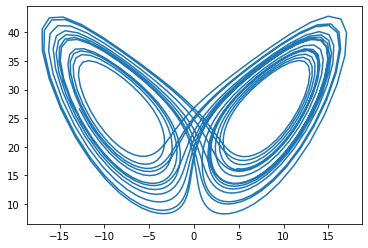

In [160]:
plt.plot(test_data[0:1000, 0], test_data[0:1000, 2])

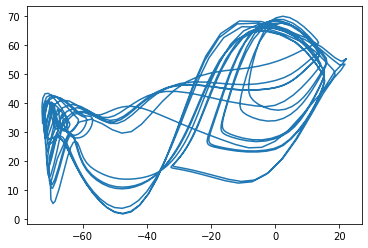

In [161]:
plt.plot(preds[0:1000, 0], preds[0:1000, 2])

In [157]:
print(rmse)
print(griffith_epsilon_1)
print(griffith_epsilon)

[3.3106124  6.29185532 1.52455424]
0.03538552809170171
0.18181225526608905
